In [1]:
from rbm_torch.utils import seq_utils as su
from rbm_torch.analysis import analysis_methods as am
from rbm_torch.utils import data_prep as dp
import numpy as np
import pandas as pd

/home/jonah/anaconda3/envs/aptamer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
thc_ct = pd.read_csv("thc_12_to_16_ct.csv")

In [3]:
round_names = ["r12", "r13", "r14", "r15", "r16"]
mins = thc_ct.loc[:, round_names].min()
dmin = mins-mins.min()
thc_ct[dmin.index] -= dmin

In [4]:
thc_ct["lr_enrichment"] = thc_ct["r16"] / thc_ct["r15"]

In [5]:
thc_ct.sort_values("lr_enrichment", ascending=False, inplace=True)
thc_ct.head(23000)

,sequence,r12,r13,r14,r15,r16,lr_enrichment
10266,GCGGGAGGGAUGGGAGGUCCGAAGCGUUGAGACCACACGGGG-,NaN,NaN,NaN,0.158796,12672.773509,79805.359148
369267,GAGGGUGGGAGGGAGAUGGGACCGAAGCACAGAAACAAGCAC-,NaN,NaN,NaN,0.158796,2868.503392,18064.075969
33838,GUGGGUGGGGGGGGAAAAGGGCACGAAGCCGGCGAGGCACAA-,0.158796,3221.840495,2912.332772,0.158796,2858.974008,18004.065749
199153,CGCGAAAAGGGAGGGUGGGAGGGGGACGCGCCAACAGAGGAC-,NaN,2313.264190,NaN,0.158796,2218.672703,13971.840639
364352,GCGGGUGGGGGGGAAGGACCGAGUCGAACACGCAUGACCGAA-,NaN,1588.012263,1724.188314,0.158796,1443.860478,9092.548203
...,...,...,...,...,...,...,...
16782,AAAAGGGAGGGUGGGAGGGGUAGGUCACGAAGCAAGAGGAC--,NaN,NaN,NaN,0.158796,0.525311,3.308085
398099,AAGGGUGGGAGGGCAGGGUCCCGAAGUGCACGACACCGGCCA-,NaN,NaN,NaN,0.158796,0.525311,3.308085
404061,AUGGCAAAGGGAGGGUGGGAGGGGCCAGCCCAGGGAGCGGAA-,NaN,0.158796,NaN,0.158796,0.525311,3.308085
428682,GCGGGUGGGAAGGGGUAGGGACCGCGCGCUCAGAACGGACAA-,0.158796,NaN,NaN,0.158796,0.525311,3.308085


In [6]:
thc_ct["log_lr_enrichment"] = np.log(thc_ct["lr_enrichment"])

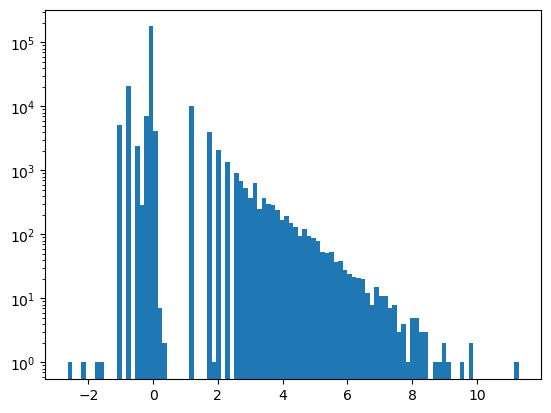

In [7]:
dp.quick_hist(thc_ct["log_lr_enrichment"].to_numpy())

In [14]:
from copy import copy
thc_ct[thc_ct["log_lr_enrichment"] > 0.0].index.__len__()
enriched = copy(thc_ct[thc_ct["log_lr_enrichment"] > 0.0])

In [ ]:
thc_ct[thc_ct["log_lr_enrichment"] > 0.0].index.__len__()

In [15]:
# takes about 10 sec (not too shabby)
thc_tokens = su.create_tokens(enriched["sequence"].tolist(), su.tokenize, cpus=12, k=5)

In [16]:
import tmap as tm

seed = 42
dims = 64
tokens = thc_tokens

CFG_TMAP = tm.LayoutConfiguration()
CFG_TMAP.k = 50
CFG_TMAP.kc = 50
CFG_TMAP.node_size = 1 / 20

enc = tm.Minhash(len(tokens), seed, dims)
lf = tm.LSHForest(dims * 2, 64, store=True)

lf.batch_add(enc.batch_from_string_array(tokens))
lf.index()

x, y, s, t, _ = tm.layout_from_lsh_forest(lf, CFG_TMAP)
lf.clear()

In [17]:
from faerun import Faerun

dataframe = enriched

dataframe["g_content"] = dataframe["sequence"].str.count("G")
dataframe["c_content"] = dataframe["sequence"].str.count("C")

plot_data = {"x": x, "y": y,"c": [dataframe["log_lr_enrichment"].to_list(), dataframe["g_content"].to_list(), dataframe["c_content"].to_list()], "labels": enriched["sequence"].to_list()}

frun = Faerun(view="front", coords=False, clear_color='#222222')
frun.add_scatter(
    "THC",
    plot_data,
    colormap=["rainbow", "rainbow"],
    point_scale=2.0,
    max_point_size=10,
    shader="smoothCircle",
    has_legend=True,
    categorical=[False, False],
    legend_title=["Log Enrichment", "G Content", "C Content"]
)
frun.add_tree(
    "THC_tree", {"from": s, "to": t}, point_helper="THC", color="#666666"
)
frun.plot("thc")

/home/jonah/PycharmProjects/phage_display_ML/datasets/thc/thc.html

In [83]:
dataframe["g_content"] = dataframe["sequence"].str.count("G")

In [71]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, LinearColorMapper, LogColorMapper, CustomJS, Slider, Select
from bokeh.palettes import Spectral10
from bokeh.transform import transform

output_notebook()

dataframe = enriched
dataframe["x"] = x
dataframe["y"] = y

round_names = ["r12", "r13", "r14", "r15", "r16"]

datasource = ColumnDataSource(dataframe)

# color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in digits.target_names], palette=Spectral10)

enrichment_values = dataframe["log_lr_enrichment"].to_numpy()
# mapper = LinearColorMapper(low=np.min(enrichment_values), high=np.max(enrichment_values), palette="Viridis256")
mapper = LogColorMapper(low=np.min(enrichment_values), high=np.max(enrichment_values), palette="Viridis256")

plot_figure = figure(
    title='TMAP projection of the THC dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset, zoom_in,zoom_out,box_zoom')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 10px'>@sequence</span>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>E:</span>
        <span style='font-size: 18px'>@log_lr_enrichment</span>
    </div>
</div>
"""))

plot_figure.scatter(x="x", y="y", color=transform("log_lr_enrichment", mapper), source=datasource)
show(plot_figure)
# Maybe Later

# minE = Slider(start=dataframe["log_enrichment"].min(), end=dataframe["log_enrichment"].max(), value=dataframe["log_enrichment"].min(), step=.01, title="Min Enrichment Value")
# maxE = Slider(start=dataframe["log_enrichment"].max(), end=dataframe["log_enrichment"].min(), value=dataframe["log_enrichment"].max(), step=.01, title="Max Enrichment Value")
#
# callback = CustomJS(args=dict(source=datasource, minE=minE, maxE=maxE),
#                     code="""
#     const minE = minE.value
#     const maxE = maxE.value
#     const phi = phase.value
#     const B = offset.value
#
#     const x = source.data.x
#     const y = Array.from(x, (x) => B + A*Math.sin(k*x+phi))
#     source.data = source.data["enrichment]
# """)
#
# amp.js_on_change('value', callback)
# freq.js_on_change('value', callback)
# phase.js_on_change('value', callback)
# offset.js_on_change('value', callback)
#
#
# # Select widget
# menu = Select(options=round_names, value='Show both parties')



Loading BokehJS ...

In [67]:
enriched.head()

,sequence,r12,r13,r14,r15,r16,lr_enrichment,log_lr_enrichment,x,y
10266,GCGGGAGGGAUGGGAGGUCCGAAGCGUUGAGACCACACGGGG-,NaN,NaN,NaN,0.158796,12672.773509,79805.359148,11.287346,-0.041690,-0.473482
369267,GAGGGUGGGAGGGAGAUGGGACCGAAGCACAGAAACAAGCAC-,NaN,NaN,NaN,0.158796,2868.503392,18064.075969,9.801680,-0.275479,-0.101892
33838,GUGGGUGGGGGGGGAAAAGGGCACGAAGCCGGCGAGGCACAA-,0.158796,3221.840495,2912.332772,0.158796,2858.974008,18004.065749,9.798353,0.074520,0.333233
199153,CGCGAAAAGGGAGGGUGGGAGGGGGACGCGCCAACAGAGGAC-,NaN,2313.264190,NaN,0.158796,2218.672703,13971.840639,9.544799,-0.190394,0.253164
364352,GCGGGUGGGGGGGAAGGACCGAGUCGAACACGCAUGACCGAA-,NaN,1588.012263,1724.188314,0.158796,1443.860478,9092.548203,9.115210,0.291583,-0.125578


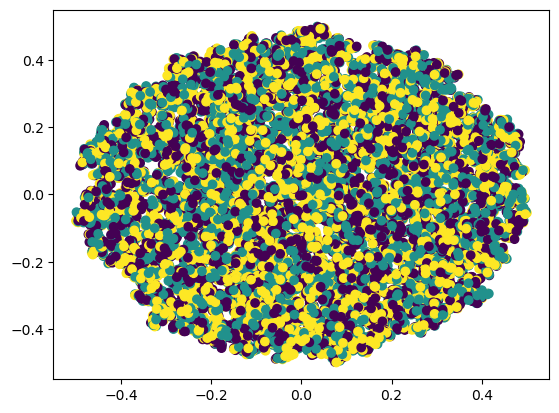

In [21]:
import matplotlib.pyplot as plt
labels = np.random.randint(0, 3, size=(len(tokens)))
plt.scatter(x, y, c=labels)
plt.show()